In [1]:
from skimage.io import imread
import cv2
import numpy as np
from scipy import fftpack
import scipy.ndimage as ndi
from skimage import io, color, filters, feature, segmentation, measure, draw, exposure, transform
import matplotlib.pylab as plt

In [2]:
def angle_to_slope(angle):
    return np.tan(angle + (np.pi/2))

def angles_dists_to_points(angles, dists):
    x_coords = dists * np.cos(angles)
    y_coords = dists * np.sin(angles)
    return x_coords, y_coords

def angles_dists_to_points_slopes(angles, dists):
    x_coords = dists * np.cos(angles)
    y_coords = dists * np.sin(angles)
    slopes = [angle_to_slope(a) for a in angles]
    return x_coords, y_coords, slopes

In [3]:
def plot_lines_hough(im, angles, dists, points=[], line_color='red', point_color='blue'):
    x_coords, y_coords = angles_dists_to_points(angles, dists)
    plt.imshow(im,cmap='gray')
    # Force the limits on the axes
    h, w = im.shape
    plt.xlim((0, w))
    plt.ylim((h, 0))
    HOUGH_LINES_DISPLAY_WIDTH = 4
    # Plot the lines
    for x, y, angle in zip(x_coords, y_coords, angles):
        # plt.plot(x, y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
        plt.axline((x, y), slope=angle_to_slope(angle), color=line_color, linewidth=HOUGH_LINES_DISPLAY_WIDTH)

    # Plot the points
    for x, y in points:
        plt.plot(x, y, color=point_color, marker='o', linestyle='dashed', linewidth=2, markersize=12)

In [4]:
def hough_lines(im):
    # Perform the Hough line transform
    hspace, angles, dists = transform.hough_line(im)
    # Get the peak values, angles, and distances of the most prominent lines
    peak_vals, angles, dists = transform.hough_line_peaks(hspace, angles, dists)

    # Return the filtered angles and distances
    return angles, dists

In [5]:
def findSize(file_path):
    im =  np.mean(imread(file_path), axis=2) / 255
    h,w=im.shape
    F1 = fftpack.fft2((im).astype(float))
    F2 = fftpack.fftshift( F1 )
    w=round(w/2)
    h=round(h/2)
    # eliminate the frequencies most likely responsible for noise (keep some low frequency components)
    F2[h-1:h+1,w-10:w-6] = F2[h-1:h+1,w+6:w+10] = 0
    im_board = fftpack.ifft2(fftpack.ifftshift( F2 )).real
    #blurred =  exposure.equalize_hist(im_board)
    blurred = ndi.median_filter(im_board,size=3) # blur
    edges = filters.sobel(blurred) # detect edges
    EDGE_DETECTION_THRESHOLD = 0.02
    thresh = edges > EDGE_DETECTION_THRESHOLD # threshold
    angles, dists= hough_lines(thresh)
    col=0
    row=0
    angles_row=[] 
    dists_row = []
    for i in range(len(angles)):
        if(abs(angles[i])<1):
            col+=1
        else:
            angles_row.append(angles[i])
            dists_row.append(dists[i])
            row+=1
    print("Size of chessboard: ",col+1,row+1)
    print("Column: ",col+1)
    print("Row: ",row+1)
    plot_lines_hough(thresh, angles, dists)

In [10]:
file_path=r'F:\slide\20222\xla\Proj1.1\Chessboard_0481.png'

Size of chessboard:  9 9
Column:  9
Row:  9


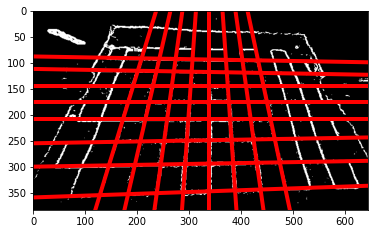

In [11]:
findSize(file_path)

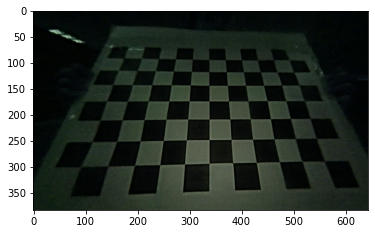

In [12]:
img = cv2.imread(file_path)
plt.imshow(img)

The number of square: 48. 


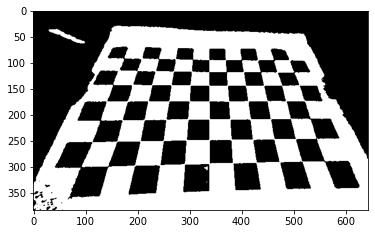

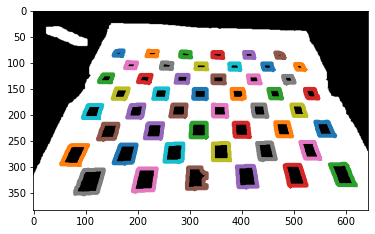

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from skimage.filters import rank
from skimage.morphology import ball
# Local equalization
neighborhood = ball(3)
img_eq = rank.equalize(img, footprint=neighborhood)
# Load image, grayscale, median blur, sharpen image
image = cv2.imread(r'F:\slide\20222\xla\Proj1.1\Chessboard_0481.png')
#mask = np.zeros(image.shape, dtype=np.uint8)
#original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# clahe = cv2.createCLAHE(clipLimit=2,tileGridSize=(3,3))
# gray = clahe.apply(gray)
# Local equalization


gray = cv2.equalizeHist(gray)
blur = cv2.medianBlur(gray, 3)
#thresh = cv2.equalizeHist(blur)
thresh = cv2.threshold(blur, 5, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
#thresh = cv2.Canny(thresh, 10, 200)
# Remove noise with morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
plt.imshow(opening,cmap='gray')
kernel = np.ones((11, 11), np.uint8)
  

opening = cv2.dilate(opening, kernel, iterations=1)

# Find contours using scikit-image
contours = measure.find_contours(opening, 1)

# Plot the image with contours overlaid
fig, ax = plt.subplots()
ax.imshow(opening, cmap=plt.cm.gray)
max_dots_shape = 225
min_dots_shape = 5

for cnt in contours:
    if np.shape(cnt)[0] < max_dots_shape and np.shape(cnt)[0] > min_dots_shape:
        ax.plot(cnt[:, 1], cnt[:, 0], linewidth=4)

dots_contours = [cnt for cnt in contours if np.shape(cnt)[0] < max_dots_shape and np.shape(cnt)[0] > min_dots_shape]
print("The number of square: {}. ".format(len(dots_contours)))
